# 1. import needed package

In [1]:
from mxnet import autograd
from mxnet import gluon
from mxnet import image
from mxnet import init
from mxnet import nd
from mxnet.gluon.model_zoo import vision as model
from mxnet.gluon import nn
from mxnet.gluon.data import vision
import numpy as np
import random
import mxnet as mx
import sys
sys.path.insert(0, '../../utils')
from netlib import *
import os
import shutil

ctx = mx.gpu(4)

def mkdir_if_not_exist(path):
    if not os.path.exists(os.path.join(*path)):
        os.makedirs(os.path.join(*path))

# 2. data loader, data argument

In [2]:
"""
data loader
"""
def _transform_test(data, label):
    im = data.astype('float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), mean=np.array([0.4914, 0.4822, 0.4465]),
                                   std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1))
    return im, nd.array([label]).astype('float32')


def data_loader(batch_size, transform_train, transform_test=None, num_workers=0):
    if transform_train is None:
        transform_train = _transform_train
    if transform_test is None:
        transform_test = _transform_test
        
    # flag=1 mean 3 channel image
    train_ds = gluon.data.vision.datasets.CIFAR10(root='~/.mxnet/datasets/cifar10', train=True, transform=transform_train)
    test_ds = gluon.data.vision.datasets.CIFAR10(root='~/.mxnet/datasets/cifar10', train=False, transform=transform_test)

    loader = gluon.data.DataLoader
    train_data = loader(train_ds, batch_size, shuffle=True, last_batch='keep', num_workers=num_workers)
    test_data = loader(test_ds, batch_size, shuffle=False, last_batch='keep', num_workers=num_workers)
    return train_data, test_data

In [3]:
"""
data argument
"""
def transform_train_DA1(data, label):
    im = data.asnumpy()
    im = np.pad(im, ((4, 4), (4, 4), (0, 0)), mode='constant', constant_values=0)
    im = nd.array(im, dtype='float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, rand_mirror=True,
                                    rand_crop=True,
                                   mean=np.array([0.4914, 0.4822, 0.4465]),
                                   std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1)) # channel x width x height
    return im, nd.array([label]).astype('float32')


def transform_train_DA2(data, label):
    im = data.astype(np.float32) / 255
    auglist = [image.RandomSizedCropAug(size=(32, 32), min_area=0.49, ratio=(0.5, 2))]
    _aug = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, 
                                rand_crop=False, rand_resize=False, rand_mirror=True,
                                mean=np.array([0.4914, 0.4822, 0.4465]),
                                std=np.array([0.2023, 0.1994, 0.2010]),
                                brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3,
                                pca_noise=0.01, rand_gray=0, inter_method=2)
    auglist.append(image.RandomOrderAug(_aug))
    
    for aug in auglist:
        im = aug(im)
    
    im = nd.transpose(im, (2, 0, 1))
    return (im, nd.array([label]).asscalar().astype('float32'))
    

random_clip_rate = 0.3
def transform_train_DA3(data, label):
    im = data.astype(np.float32) / 255
    auglist = [image.RandomSizedCropAug(size=(32, 32), min_area=0.49, ratio=(0.5, 2))]
    _aug = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, 
                                rand_crop=False, rand_resize=False, rand_mirror=True,
#                                mean=np.array([0.4914, 0.4822, 0.4465]),
#                                std=np.array([0.2023, 0.1994, 0.2010]),
                                brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3,
                                pca_noise=0.01, rand_gray=0, inter_method=2)
    auglist.append(image.RandomOrderAug(_aug))

    for aug in auglist:
        im = aug(im)
        
    if random.random() > random_clip_rate:
        im = im.clip(0, 1)
    _aug = image.ColorNormalizeAug(mean=np.array([0.4914, 0.4822, 0.4465]),
                   std=np.array([0.2023, 0.1994, 0.2010]),)
    im = _aug(im)
    
    im = nd.transpose(im, (2, 0, 1))
    return (im, nd.array([label]).asscalar().astype('float32'))

# 3 data aurgument: mixup
1. mixup define
2. mixup visualize

## 3.1 mixup: define

In [4]:
import numpy as np
def mixup(x1, y1, x2, y2, alpha, num_class):
    y1 = nd.one_hot(y1, num_class)
    y2 = nd.one_hot(y2, num_class)
    
    lam = np.random.beta(alpha, alpha)
    x = lam * x1 + (1 - lam) * x2
    y = lam * y1 + (1 - lam) * y2
    return x, y

## 3.2 mixup: visulize

In [5]:
from mxnet import gluon
from mxnet.gluon.model_zoo import vision as model
from time import time
batch_size = 32
transform_train = _transform_test#transform_train_DA1
train_data, test_data = data_loader(batch_size, transform_train)
mixup_alpha = 1

# for x1, y1 in train_data:
#     for x2, y2 in mixup_train_data:
#         data, label = mixup(x1, y1, x2, y2, mixup_alpha, 10)
#         break
#     break

for x, y in train_data:
    l = x.shape[0] / 2
    data, label = mixup(x[:l], y[:l], x[l:2*l], y[l:2*l], mixup_alpha, 10)
    break

/root/Util/miniconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/root/Util/miniconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/root/Util/miniconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/root/Util/miniconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:95: DeprecationWarning: metadata {'config': True} was set from the constructor. 

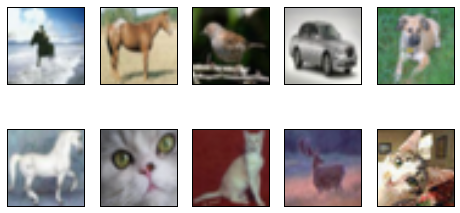

[(0, 'airplane'), (1, 'automobile'), (2, 'bird'), (3, 'cat'), (4, 'deer'), (5, 'dog'), (6, 'frog'), (7, 'horse'), (8, 'ship'), (9, 'truck')]

[[[ 0.          0.          0.          0.          0.          0.          0.
    0.95118421  0.04881578  0.        ]]

 [[ 0.04881578  0.          0.          0.          0.          0.          0.
    0.95118421  0.          0.        ]]

 [[ 0.          0.04881578  0.95118421  0.          0.          0.          0.
    0.          0.          0.        ]]

 [[ 0.          0.95118421  0.          0.          0.          0.          0.
    0.04881578  0.          0.        ]]

 [[ 0.          0.          0.          0.          0.          0.95118421
    0.          0.          0.04881578  0.        ]]

 [[ 0.          0.          0.          0.04881578  0.          0.          0.
    0.95118421  0.          0.        ]]

 [[ 0.          0.          0.          0.95118421  0.          0.          0.
    0.          0.04881578  0.        ]]

 [[

In [6]:
from cifar10_utils import show_images
%matplotlib inline
mean=np.array([0.4914, 0.4822, 0.4465])
std=np.array([0.2023, 0.1994, 0.2010])
images = data[:10].transpose((0, 2, 3, 1)).asnumpy()
images = images * std + mean
images = images.transpose((0, 3, 1, 2)) * 255
show_images(images)
#show_images(data[:9], rgb_mean=mean*255, std=std*255)

print [(i, l) for i, l in enumerate(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])]
print label[:10]

## 3.3 mixup: train

In [7]:
from time import time
mixup_test = False

if mixup_test:
    net = ResNet164_v2(10)
    net.collect_params().initialize(mx.init.Xavier(), ctx=ctx, force_reinit=True)
    loss_f = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=False)

    num_epochs = 1
    learning_rate = 0.1
    weight_decay = 1e-4

    cur_time = time()
    iters = 0
    """
    data loader first time run will cost about 3x time than after run.
    """
    for x1, y1 in train_data:
        if iters % 100 == 0:
            print iters, time() - cur_time
        iters += 1
    print "cost time:", time() - cur_time
    print
    cur_time = time()

    iters = 0
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1, 'momentum': 0.9, 'wd': 1e-4})
    for x, y in train_data:
        l = x.shape[0] / 2
        data, label = mixup(x[:l], y[:l], x[l:2*l], y[l:2*l], mixup_alpha, 10)

        with autograd.record():
            output = net(data.as_in_context(ctx))
            loss = loss_f(output, label.as_in_context(ctx))
        loss.backward()
        trainer.step(data.shape[0])

        if iters % 100 == 0:
            print iters, time() - cur_time, nd.mean(loss).asscalar()
        iters += 1
    print iters, time() - cur_time

    # load data one by one batch
    # iters = 0
    # for x1, y1 in train_data:
    #     for x2, y2 in mixup_train_data:
    #         data, label = mixup(x1, y1, x2[:x1.shape[0]], y2[:y1.shape[0]], mixup_alpha, 10)
    #         break
    #     if iters % 100 == 0:
    #         print iters, time() - cur_time
    #     iters += 1
    # print "cost time:", time() - cur_time
    # print
    # cur_time = time()

    # zip will load all datas and then iterate them, too cost memory, will drop speed when memory over.
    # iters = 0
    # for (x1, y1), (x2, y2) in zip(train_data, mixup_train_data):
    #     data, label = mixup(x1, y1, x2, y2, mixup_alpha, 10)
    #     if iters % 100 == 0:
    #         print iters, time() - cur_time#, nd.mean(loss).asscalar()
    #     iters += 1
    # print time() - cur_time

# 4. define train function

In [8]:
"""
train
"""
import datetime
import utils
import sys

def abs_mean(W):
    return nd.mean(nd.abs(W)).asscalar()

def in_list(e, l):
    for i in l:
        if i == e:
            return True
    else:
        return False

def train(net, train_data, valid_data, num_epochs, lr, lr_period, 
          lr_decay, wd, ctx, w_key, output_file=None, verbose=False, loss_f=gluon.loss.SoftmaxCrossEntropyLoss(), 
          use_mixup=False, mixup_alpha=0.2):
    def train_batch(data, label, i):
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data.as_in_context(ctx))
            loss = loss_f(output, label)
        loss.backward()
        trainer.step(data.shape[0])

        _loss = nd.mean(loss).asscalar()
        if not use_mixup:
            _acc = utils.accuracy(output, label)
        else:
            _acc = None

        if verbose and i % 100 == 0:
            print " # iter", i,
            print "loss %.5f" % _loss, 
            if not use_mixup: print "acc %.5f" % _acc,
            print "w (",
            for k in w_key:
                w = net.collect_params()[k]
                print "%.5f, " % abs_mean(w.data()),
            print ") g (",
            for k in w_key:
                w = net.collect_params()[k]
                print "%.5f, " % abs_mean(w.grad()),
            print ")"
        return _loss, _acc
            
    if output_file is None:
        output_file = sys.stdout
        stdout = sys.stdout
    else:
        output_file = open(output_file, "w")
        stdout = sys.stdout
        sys.stdout = output_file
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr, 'momentum': 0.9, 'wd': wd})
    prev_time = datetime.datetime.now()
    
    if verbose:
        print " #", utils.evaluate_accuracy(valid_data, net, ctx)
    
    i = 0
    for epoch in range(num_epochs):
        train_loss = 0.
        train_acc = 0.
        if in_list(epoch, lr_period):
            trainer.set_learning_rate(trainer.learning_rate * lr_decay)
            
        if not use_mixup:
            for data, label in train_data:
                _loss, _acc = train_batch(data, label, i)
                train_loss += _loss
                train_acc += _acc
                i += 1
        else:
            for x, y in train_data:
                l = x.shape[0] / 2
                data, label = mixup(x[:l], y[:l], x[l:2*l], y[l:2*l], mixup_alpha, 10)
                _loss, _ = train_batch(data, label, i)
                train_loss += _loss
                i += 1
        
        cur_time = datetime.datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        
        train_loss /= len(train_data)
        train_acc /= len(train_data)
        if train_acc < 1e-6:
            train_acc = utils.evaluate_accuracy(train_data, net, ctx)
        
        if valid_data is not None:
            valid_acc = utils.evaluate_accuracy(valid_data, net, ctx)
            epoch_str = ("epoch %d, loss %.5f, train_acc %.4f, valid_acc %.4f" 
                         % (epoch, train_loss, train_acc, valid_acc))
        else:
            epoch_str = ("epoch %d, loss %.5f, train_acc %.4f"
                        % (epoch, train_loss, train_acc))
        prev_time = cur_time
        output_file.write(epoch_str + ", " + time_str + ",lr " + str(trainer.learning_rate) + "\n")
        output_file.flush()  # to disk only when flush or close
    if output_file != stdout:
        sys.stdout = stdout
        output_file.close()

# 5. get net and do EXP
```
I want to find out the reason that resnet18_v2 get fail baseline in CIFAR10_train2_* script, design follow exp.

1. 5.1 train my resnet18 to repreduce baseline(0.93 acc), to make sure code is no bugs.
2. 5.2 train gluon resnet18 use same hyper-param, get failed baseline(0.85 acc), so i thought the reason may cause by gluon resnet18 and my resnet18.
 there are three diff between them(I thought the diff may cause gluon resnet is design for imagenet and my gluon is design for CIFAR10):<br/>
    a. first conv use diff kernel size and padding size:conv(k=7,p=3,s=1) vs conv(k=3,p=1,s=1)
    b. after first block, gluon resnet18 use maxpool and my resnet not use
    c. gluon resnet18 use 4 * 2 block with channel size [64, 128, 256, 512] and three downsample, and my resnet18 use 3 * 3 block with channle size [32, 64, 128] and two downsample, so last layer use global avg pooling.
    it may said delay pooling is useful, pool to early is not good.
```


## 5.1 re-exp resnet18_v1
train my resnet18 to repreduce baseline(0.93 acc), to make sure code is no bugs.

In [9]:
net = ResNet(10)
net.load_params('../../models/res18_9', ctx=ctx)
valid_acc = utils.evaluate_accuracy(test_data, net, ctx)
print valid_acc
def get_net(ctx):
    num_outputs = 10
    net = ResNet(num_outputs)
    net.collect_params().initialize(init=init.Xavier(), ctx=ctx, force_reinit=True)
    return net  

0.932408146965


In [18]:
num_epochs = 80
learning_rate = 0.1
weight_decay = 5e-4
lr_period = [80]
lr_decay=0.1
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=4)
net = get_net(ctx)
net.hybridize()
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f)

net.save_params("../../models/resnet18_me_80e_aug")

epoch 0, loss 1.80346, train_acc 0.3266, valid_acc 0.3598, Time 00:00:28,lr 0.1
epoch 1, loss 1.28281, train_acc 0.5411, valid_acc 0.5778, Time 00:00:31,lr 0.1
epoch 2, loss 1.01865, train_acc 0.6431, valid_acc 0.6533, Time 00:00:30,lr 0.1
epoch 3, loss 0.90869, train_acc 0.6870, valid_acc 0.5823, Time 00:00:30,lr 0.1
epoch 4, loss 0.85972, train_acc 0.7049, valid_acc 0.6255, Time 00:00:31,lr 0.1
epoch 5, loss 0.82922, train_acc 0.7158, valid_acc 0.6503, Time 00:00:31,lr 0.1
epoch 6, loss 0.81416, train_acc 0.7211, valid_acc 0.6621, Time 00:00:31,lr 0.1
epoch 7, loss 0.79129, train_acc 0.7286, valid_acc 0.6731, Time 00:00:31,lr 0.1
epoch 8, loss 0.79221, train_acc 0.7293, valid_acc 0.6960, Time 00:00:31,lr 0.1
epoch 9, loss 0.77941, train_acc 0.7357, valid_acc 0.7085, Time 00:00:30,lr 0.1
epoch 10, loss 0.77304, train_acc 0.7350, valid_acc 0.6773, Time 00:00:33,lr 0.1
epoch 11, loss 0.77300, train_acc 0.7362, valid_acc 0.6708, Time 00:00:32,lr 0.1
epoch 12, loss 0.77379, train_acc 0.73

In [10]:
num_epochs = 120
learning_rate = 0.05
weight_decay = 1e-3
lr_period = [30, 60, 90]
lr_decay=0.2
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

net = get_net(ctx)
net.load_params("../../models/resnet18_me_80e_aug", ctx=ctx)

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=4)
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f)
net.save_params('../../models/resnet18_me_9')

epoch 0, loss 0.61285, train_acc 0.7915, valid_acc 0.7278, Time 00:00:31,lr 0.05
epoch 1, loss 0.68711, train_acc 0.7663, valid_acc 0.6986, Time 00:00:31,lr 0.05
epoch 2, loss 0.70354, train_acc 0.7601, valid_acc 0.7469, Time 00:00:31,lr 0.05
epoch 3, loss 0.70402, train_acc 0.7604, valid_acc 0.6044, Time 00:00:31,lr 0.05
epoch 4, loss 0.70819, train_acc 0.7573, valid_acc 0.7099, Time 00:00:31,lr 0.05
epoch 5, loss 0.71752, train_acc 0.7569, valid_acc 0.7387, Time 00:00:31,lr 0.05
epoch 6, loss 0.71241, train_acc 0.7581, valid_acc 0.7282, Time 00:00:32,lr 0.05
epoch 7, loss 0.71346, train_acc 0.7582, valid_acc 0.7717, Time 00:00:32,lr 0.05
epoch 8, loss 0.71035, train_acc 0.7555, valid_acc 0.7430, Time 00:00:32,lr 0.05
epoch 9, loss 0.71255, train_acc 0.7570, valid_acc 0.7069, Time 00:00:32,lr 0.05
epoch 10, loss 0.71683, train_acc 0.7539, valid_acc 0.5970, Time 00:00:32,lr 0.05
epoch 11, loss 0.71341, train_acc 0.7572, valid_acc 0.7481, Time 00:00:31,lr 0.05
epoch 12, loss 0.71346, tr

## 5.2 mixup with my resnet18 pretrain

In [13]:
num_epochs = 120
learning_rate = 0.05
weight_decay = 1e-3
lr_period = [30, 60, 90]
lr_decay=0.2
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=False)

net = ResNet(10)
net.collect_params().initialize(init=init.Xavier(), ctx=ctx, force_reinit=True)
net.load_params("../../models/resnet18_me_80e_aug", ctx=ctx)

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=3)
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f, True, 1.0)
net.save_params('../../models/resnet18_me_9_mixup')

epoch 0, loss 1.46284, train_acc 0.0000, valid_acc 0.7072, Time 00:02:58,lr 0.05
epoch 1, loss 1.53072, train_acc 0.0000, valid_acc 0.6142, Time 00:02:58,lr 0.05
epoch 2, loss 1.55268, train_acc 0.0000, valid_acc 0.5828, Time 00:02:59,lr 0.05
epoch 3, loss 1.55454, train_acc 0.0000, valid_acc 0.6198, Time 00:02:44,lr 0.05
epoch 4, loss 1.55578, train_acc 0.0000, valid_acc 0.4324, Time 00:03:03,lr 0.05
epoch 5, loss 1.56134, train_acc 0.0000, valid_acc 0.6122, Time 00:02:58,lr 0.05
epoch 6, loss 1.56088, train_acc 0.0000, valid_acc 0.5651, Time 00:02:50,lr 0.05
epoch 7, loss 1.57644, train_acc 0.0000, valid_acc 0.6191, Time 00:02:37,lr 0.05
epoch 8, loss 1.56583, train_acc 0.0000, valid_acc 0.6999, Time 00:02:42,lr 0.05
epoch 9, loss 1.56109, train_acc 0.0000, valid_acc 0.5963, Time 00:02:45,lr 0.05
epoch 10, loss 1.57972, train_acc 0.0000, valid_acc 0.6087, Time 00:03:01,lr 0.05
epoch 11, loss 1.56302, train_acc 0.0000, valid_acc 0.6333, Time 00:04:24,lr 0.05
epoch 12, loss 1.56775, tr

In [9]:
num_epochs = 30
learning_rate = 0.00008
weight_decay = 1e-3
lr_period = [30]
lr_decay=0.2
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=False)

net = ResNet(10)
net.collect_params().initialize(init=init.Xavier(), ctx=ctx, force_reinit=True)
net.load_params('../../models/resnet18_me_9_mixup', ctx=ctx)
net.hybridize()

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=3)
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f, True, 1.0)
net.save_params('../../models/resnet18_me_9_mixup2')

epoch 0, loss 1.06381, train_acc 0.0000, valid_acc 0.9175, Time 00:02:36,lr 8e-05
epoch 1, loss 1.06595, train_acc 0.0000, valid_acc 0.9169, Time 00:02:18,lr 8e-05
epoch 2, loss 1.06346, train_acc 0.0000, valid_acc 0.9173, Time 00:02:32,lr 8e-05
epoch 3, loss 1.06546, train_acc 0.0000, valid_acc 0.9197, Time 00:02:26,lr 8e-05
epoch 4, loss 1.06340, train_acc 0.0000, valid_acc 0.9122, Time 00:02:21,lr 8e-05
epoch 5, loss 1.05059, train_acc 0.0000, valid_acc 0.9203, Time 00:02:35,lr 8e-05
epoch 6, loss 1.05504, train_acc 0.0000, valid_acc 0.9171, Time 00:02:24,lr 8e-05
epoch 7, loss 1.05808, train_acc 0.0000, valid_acc 0.9198, Time 00:02:24,lr 8e-05
epoch 8, loss 1.04652, train_acc 0.0000, valid_acc 0.9165, Time 00:02:32,lr 8e-05
epoch 9, loss 1.04282, train_acc 0.0000, valid_acc 0.9216, Time 00:02:33,lr 8e-05
epoch 10, loss 1.05056, train_acc 0.0000, valid_acc 0.9180, Time 00:02:31,lr 8e-05
epoch 11, loss 1.04162, train_acc 0.0000, valid_acc 0.9178, Time 00:03:49,lr 8e-05
epoch 12, loss

## 5.3 pure mixup with resnet18, general lr

In [9]:
5num_epochs = 200
learning_rate = 0.1
weight_decay = 1e-4
lr_period = [80, 150]
lr_decay=0.1
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=False)

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=3)
net = ResNet(10)
net.collect_params().initialize(init=init.Xavier(), ctx=ctx, force_reinit=True)
net.hybridize()
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f, True, 1.0)

net.save_params("../../models/resnet18_me_mixup_200e")

epoch 0, loss 2.16593, train_acc 0.3018, valid_acc 0.3185, Time 00:02:24,lr 0.1
epoch 1, loss 1.97320, train_acc 0.3922, valid_acc 0.3997, Time 00:02:43,lr 0.1
epoch 2, loss 1.87724, train_acc 0.4802, valid_acc 0.4904, Time 00:02:46,lr 0.1
epoch 3, loss 1.77747, train_acc 0.5290, valid_acc 0.5330, Time 00:02:51,lr 0.1
epoch 4, loss 1.70237, train_acc 0.6065, valid_acc 0.6088, Time 00:02:49,lr 0.1
epoch 5, loss 1.64160, train_acc 0.6250, valid_acc 0.6280, Time 00:02:50,lr 0.1
epoch 6, loss 1.59686, train_acc 0.6751, valid_acc 0.6758, Time 00:02:49,lr 0.1
epoch 7, loss 1.56121, train_acc 0.6758, valid_acc 0.6765, Time 00:02:50,lr 0.1
epoch 8, loss 1.52487, train_acc 0.6424, valid_acc 0.6397, Time 00:02:50,lr 0.1
epoch 9, loss 1.49709, train_acc 0.6987, valid_acc 0.6961, Time 00:02:50,lr 0.1
epoch 10, loss 1.50484, train_acc 0.7280, valid_acc 0.7212, Time 00:02:46,lr 0.1
epoch 11, loss 1.47519, train_acc 0.6725, valid_acc 0.6656, Time 00:02:48,lr 0.1
epoch 12, loss 1.45798, train_acc 0.76

In [10]:
num_epochs = 100
learning_rate = 0.0001
weight_decay = 1e-4
lr_period = [80, 150]
lr_decay=0.1
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=False)

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=3)
net = ResNet(10)
net.load_params("../../models/resnet18_me_mixup_200e", ctx=ctx)
net.hybridize()
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f, True, 1.0)

epoch 0, loss 0.91652, train_acc 0.9785, valid_acc 0.9345, Time 00:01:16,lr 0.0001
epoch 1, loss 0.94320, train_acc 0.9795, valid_acc 0.9374, Time 00:01:40,lr 0.0001
epoch 2, loss 0.92188, train_acc 0.9797, valid_acc 0.9361, Time 00:01:44,lr 0.0001
epoch 3, loss 0.93006, train_acc 0.9794, valid_acc 0.9375, Time 00:01:47,lr 0.0001
epoch 4, loss 0.92912, train_acc 0.9799, valid_acc 0.9379, Time 00:01:50,lr 0.0001
epoch 5, loss 0.91764, train_acc 0.9793, valid_acc 0.9370, Time 00:01:47,lr 0.0001
epoch 6, loss 0.91927, train_acc 0.9776, valid_acc 0.9346, Time 00:01:45,lr 0.0001
epoch 7, loss 0.92124, train_acc 0.9772, valid_acc 0.9355, Time 00:01:45,lr 0.0001
epoch 8, loss 0.91778, train_acc 0.9803, valid_acc 0.9385, Time 00:01:47,lr 0.0001
epoch 9, loss 0.93585, train_acc 0.9781, valid_acc 0.9354, Time 00:01:45,lr 0.0001
epoch 10, loss 0.90313, train_acc 0.9811, valid_acc 0.9391, Time 00:01:47,lr 0.0001
epoch 11, loss 0.92697, train_acc 0.9801, valid_acc 0.9390, Time 00:03:00,lr 0.0001
ep